In [28]:
import importlib
from pathlib import Path

# from torch.utils.data import DataLoader, random_split
from torch import cuda, nn, optim
from torch.backends import mps

import matplotlib.pyplot as plt
import numpy as np

import datasets.mnist_loader as ml
from ptmodels import vae_pytorch as vp

# Use a gpu or M1 chipset to train PyTorch networks if you have it.
if cuda.is_available():
    device = 'cuda'

elif mps.is_available():
    device = 'mps'

else: 
    device = 'cpu'

print(f'Using {device}.')

Using cuda.


# Project 2: Autoencoders and Variational Autoencoders.
In this project, we are going to first implement a couple autoencoders trained on MNIST-compatible data sets for dimensionality reduction. Afterwards, we'll then create a generative model using a variational autoencoder. 

## Project 2.1: Autoencoders for Dimensionality Reduction.
High dimensionality data frequently has more dimensions than is needed to perform regression, classification, or clustering.  More formally, there is a lot of covariance within most data, covariance that reduces the intrinsic dimensionality of the data set.  Think of image data --- a $128 \times 128$ pixel image can be thought of as a vector $\mathbf{x}$ which resides in a 416384$-dimensional vector space. That does not mean there are $16384$ unique features.  Intuitively, we know there are less features in the data, and those features are captured by correlations between pixels.  In other words, we could find a mapping from the starting representation $\mathbf{x}$ to a reduced-dimension latent representation $\mathbf{z}\in \mathcal{R}^m$, where hopefully $m \ll 16384$.  We can then use more approachable latent representation $\mathbf{z}\in \mathcal{Z}$ to analyze the starting dataset $\mathbf{x}\in \mathcal{X}$.

An autoencoder does this by finding three things: a latent representation $\mathbf{z}\in \mathcal{Z}$, an encoding function $E_{\phi}(\mathbf{x})=\mathbf{z}$ parameterized by $\phi$, and a decoding function $D_{\theta}(\mathbf{z})=\mathbf{x}$ parameterized by $\theta$. Here, we will simultaneously train two dense, multi-layer perceptrons to estimate functions $E_{\phi}$ and $D_{\theta}$, recovering the latent space $\mathcal{Z}$ in the process. 

Training the perceptron networks requires a loss function.  Although the data we are training on is labeled, we will not be using them.  Instead, we are going to perform unsupervised learning.  Specifically, we'll are going to optimize by minimizing the 'distance' between the starting vector $\mathbf{x}$ and its predicted decoding $D_{\phi}(E_{\theta}(\mathbf{x}))$: 

$L(\mathcal{X}|\phi, \theta)=-\frac{1}{N}\sum^N_{i=1}L_2(\mathbf{x}_i, D_{\phi}(E_{\theta}(\mathbf{x}_i)))$

where $N$ is the size of the training data sample $\mathcal{X}$ and $L_2(\mathbf{x}, \mathbf{x}^{\prime})=|| \mathbf{x} - \mathbf{x}^{\prime} ||^2$ is the L2 loss (basically, the Euclidian distance up to some multiplicative constant). To train, we will minimize $L(\mathcal{X}|\phi, \theta)$ with respect to the parameters $\phi$ and $\theta$.

Enough math.  Let's start setting up the model to train!

In [11]:
importlib.reload(ml)
# Let's load some PyTorch DataLoaders we'll be using using a wrapper function in the 'mnist_loader.py' module.
train_dl, validation_dl = ml.load_MNISTlike(
    target_set='MNIST', batch_size_train=64, batch_size_validation=128
)

torch.Size([28, 28])
tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])


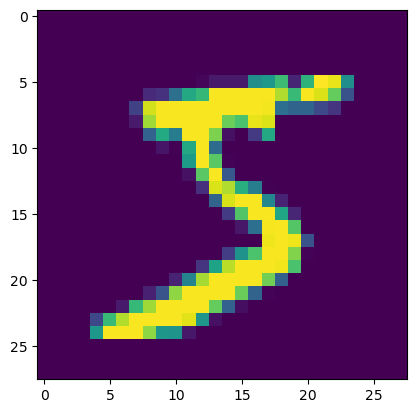

In [27]:
# Let's inspect an image
x, y = train_dl.dataset.__getitem__(0)

print(x[0].shape)  # each image is a single-channel 28 x 28 image.
print(y)  # one-hot encoding correponds to the number 5 label. 
plt.imshow(x.permute(1, 2, 0))
plt.show()

We need a loss function from Pytorch that satisfies the requirements above.  Luckily, `torch.nn.MLELoss` does just that. We'll also use the Adam optimizer.  As for the the model itself, the number of hidden layers will be four, including the final latent layer estimating $\mathcal{Z}$. The starting input dimensionality is $28 \times 28=784$ and we are going to select a latent space dimensionality space of $2$.  The remaining hidden layers will have sizes $112$ and $16$

In [48]:
# Instantiate model
n_epochs = 5
n_layers = [784, 112, 16]
n_latent = 2
ae_model = vp.SymmetricLinearAE(n_layers, n_latent)
ae_model = ae_model.to(device)  # apply model to device.

# Select optimizer.
lr = 1e-3
opt = optim.Adam(ae_model.parameters(), lr=lr)

# Select loss fuction.
loss_fn = nn.MSELoss()

In [49]:
importlib.reload(vp)
# Train model.
validation_loss = vp.train_AE(train_dl, validation_dl, ae_model, opt, loss_fn, n_epochs, device)

Batch [   64/60000] loss: 1.276754.
Batch [12864/60000] loss: 1.087383.
Batch [25664/60000] loss: 0.983046.
Batch [38464/60000] loss: 0.944331.
Batch [51264/60000] loss: 0.940921.
Epoch 1 validation loss: 0.880053.
---------------------------------------
Batch [   64/60000] loss: 0.849473.
Batch [12864/60000] loss: 0.859476.
Batch [25664/60000] loss: 0.868241.
Batch [38464/60000] loss: 0.818047.
Batch [51264/60000] loss: 0.812433.
Epoch 2 validation loss: 0.773760.
---------------------------------------
Batch [   64/60000] loss: 0.781579.
Batch [12864/60000] loss: 0.758076.
Batch [25664/60000] loss: 0.769973.
Batch [38464/60000] loss: 0.753795.
Batch [51264/60000] loss: 0.737745.
Epoch 3 validation loss: 0.727699.
---------------------------------------
Batch [   64/60000] loss: 0.757657.
Batch [12864/60000] loss: 0.795113.
Batch [25664/60000] loss: 0.720206.
Batch [38464/60000] loss: 0.711830.
Batch [51264/60000] loss: 0.696663.
Epoch 4 validation loss: 0.701322.
--------------------

tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])


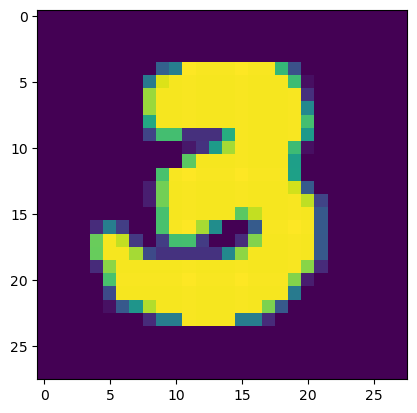

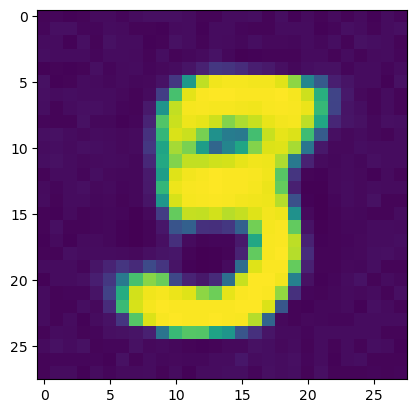

In [69]:
# Alright --- let's see how the model performs.  Note that we have to unflatten the prediction, which we do using some torch.nn functionality.

x_test, y_test = validation_dl.dataset.__getitem__(200)
x_test = x_test.to(device)

# We select the second dimension of the 2D output to unflatten into a 28x28 image.
unflatten = nn.Unflatten(1, (28, 28))

print(y_test)  # get encoding output. 
plt.imshow(x_test.to('cpu').permute(1, 2, 0))
plt.show()

x_pred = ae_model(x_test.unsqueeze(0))
# Call the unflatten object.
x_pred = unflatten(x_pred)

plt.imshow(x_pred.detach().to('cpu').permute(1, 2, 0))
plt.show()
